In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
path = './drive/MyDrive/0804'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [5]:
os.getcwd()

'/content/drive/MyDrive/0804'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [12]:
def load_data():
    data = pd.read_csv('./train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [13]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [45]:
train_x.head()

# Temp, Wind, Misture, Precipitation, Sun의
# 총 5개의 독립변수 후보가 있다!

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


(0.0, 30.0)

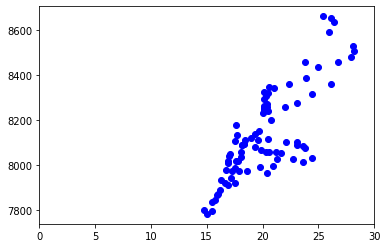

In [29]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
plt.plot(train_x.Temp, train_y, 'bo')
plt.xlim(0, 30)
# 선형 관계가 성립하는 듯 보인다!

(0.0, 30.0)

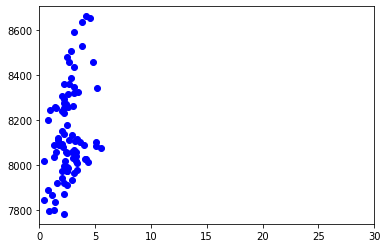

In [28]:
plt.plot(train_x.Wind, train_y, 'bo')
plt.xlim(0, 30)
# 양의 상관관계를 가진다고 할 수도 있을 것 같다..

(0.0, 100.0)

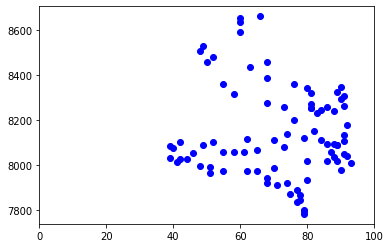

In [32]:
plt.plot(train_x.Moisture, train_y, 'bo')
plt.xlim(0, 100)
# 역시 선형관계를 파악하기 힘든 산점도이다.

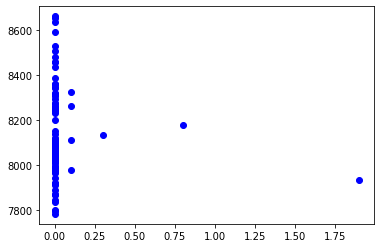

In [24]:
plt.plot(train_x.Precipitation, train_y, 'bo')

# Precipitation의 경우 대부분의 값이 0.0인 듯하다
# 값의 다양성이 떨어져서, 좋은 결과를 낼 수 있을지 의문이다.

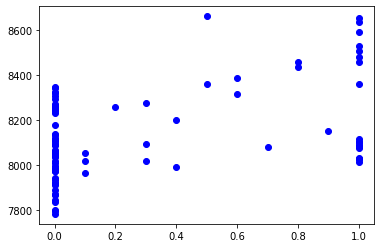

In [25]:
plt.plot(train_x.Sun, train_y, 'bo')
# 약하지만 data가 우상향하는 모양새를 보인다?

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : Temp, Wind, Sun을 선택하겠습니다!

이유: 산점도를 그려 보았을 때 비교적 선형 관계가 존재한다고 할 수 있을 정도의 결과가 나왔기 때문에.<br>
(Precipitation, Moisture는 특별한 관계를 파악하기 힘들었다)

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [33]:
# 사용할 패키지를 import!
# Standard Scaler를 사용해 보겠습니다

from sklearn.preprocessing import StandardScaler

In [38]:
train_x_new = train_x.iloc[:, [0, 1, 4]]
train_x_new.head()

# 앞서 선택한 Temp, Wind, Sun만 남기고 사용합니다!

,Temp,Wind,Sun
0,17.6,2.5,0.0
1,17.7,2.9,0.0
2,17.5,3.2,0.0
3,17.1,3.2,0.0
4,17.0,3.3,0.0


In [48]:
scaler = StandardScaler()
scaler = scaler.fit(train_x_new)

train_x_processed = scaler.transform(train_x_new)
train_x_processed

array([[-0.80942259, -0.12139024, -0.70431807],
       [-0.77879955,  0.25016944, -0.70431807],
       [-0.84004563,  0.5288392 , -0.70431807],
       [-0.96253778,  0.5288392 , -0.70431807],
       [-0.99316082,  0.62172912, -0.70431807],
       [-1.02378386,  0.71461904, -0.70431807],
       [-1.08502994,  0.71461904, -0.70431807],
       [-1.02378386, -0.30717008, -0.46220873],
       [-0.74817651,  0.62172912,  0.02200994],
       [-0.28883093, -0.49294992,  0.99044729],
       [ 0.07864553,  0.71461904,  1.7167753 ],
       [ 0.56861415,  0.90039888,  1.7167753 ],
       [ 0.87484454,  1.27195856,  1.7167753 ],
       [ 0.87484454,  2.29374768,  1.7167753 ],
       [ 1.02795973,  2.29374768,  1.7167753 ],
       [ 1.08920581,  2.66530736,  1.7167753 ],
       [ 1.27294404,  0.34305936,  1.7167753 ],
       [ 1.02795973,  1.64351824,  1.7167753 ],
       [ 0.75235238,  1.36484848,  1.7167753 ],
       [ 0.32362984,  1.4577384 ,  1.7167753 ],
       [-0.13571574, -0.12139024,  0.264

In [49]:
train_x_processed.shape

(88, 3)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [50]:
# 사용할 패키지를 import!
# Linear Regression을 활용해 보도록 하겠습니다.

from sklearn.linear_model import LinearRegression

In [52]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
linear_model = LinearRegression().fit(train_x_processed, train_y)
linear_pred_y = linear_model.predict(train_x_processed)

In [63]:
linear_model.coef_

array([232.9797736 ,   0.86547708, -90.27704453])

In [61]:
linear_model.intercept_

8142.186272727273

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [72]:
esti_y = linear_model.predict(train_x_processed)

In [73]:
esti_y

array([8017.08587415, 8024.54199916, 8010.51408421, 7981.97588972,
       7974.92173519, 7967.86758067, 7953.59848342, 7945.1263302 ,
       7966.42737797, 7985.05321653, 8006.14217706, 8120.45574322,
       8192.12280583, 8193.0071409 , 8228.67988402, 8243.27055765,
       8284.06799696, 8228.11712534, 8163.66500544, 8063.86171882,
       8086.61828224, 8088.43136038, 8038.08754953, 7988.14570917,
       7945.01684105, 7915.83549378, 7894.67303021, 7879.84117428,
       7865.97404752, 7816.35378355, 7831.34642767, 7866.37601801,
       7902.6919139 , 7967.14403379, 7995.68222828, 8010.03171963,
       7924.65831844, 8009.71014324, 8195.47868477, 8252.28479641,
       8287.74545228, 8274.57277735, 8231.04193874, 8210.04026335,
       8181.66285706, 8159.9376348 , 8138.13201845, 8116.32640209,
       8073.51911036, 8066.62574403, 8059.33040721, 8058.92843672,
       8051.95467629, 8051.7938881 , 8015.39759811, 8000.89420962,
       7969.79718612, 8156.59706882, 8286.40784768, 8343.67411

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [70]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [74]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 11423.02779


In [ ]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [ ]:
# visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [75]:
# transform을 하시는 분들은 실행해주세요
test_x = test_x.iloc[:, [0,1,4]]
test_x = scaler.transform(test_x)

In [76]:
# y1_hat에 predict값 할당
pred_y = linear_model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [77]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [78]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 141348.44777


In [79]:
score(train_mse,test_mse)

 12.3740


In [ ]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!